In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pickle

In [2]:
pd.options.mode.chained_assignment = None

In [16]:
df = pd.read_csv("final_df_10x")

## Feature Engineering

### Remove missed/ still on Trades

In [17]:
def drop_missed_trades(df):
    df = df.drop(df[df["win_loss"] == "missed"].index)
    df = df.drop(df[df["win_loss"] == "still on"].index)
    
    return df

In [18]:
df = drop_missed_trades(df)

### Removing Missing Values

In [20]:
def remove_missing_values(df):
    df = df.rename(columns={"Unnamed: 0": "index"})
    df = df.set_index("index")
    df = df.dropna()
    
    return df

In [21]:
df = remove_missing_values(df)

### Win Trades compared to Loss Trades (Win-Loss-Relation)

In [22]:
df

,time,open,high,low,close,Upper,Basis,Lower,MA,Volume,...,Histogram,MACD,Signal,name,sector,entry,stop_loss,bullishPB,triggered,win_loss
index,,,,,,,,,,,,,,,,,,,,,
229,2014-04-03 13:30:00+00:00,1.3130,1.3650,1.2155,1.36500,2.454640,1.659454,0.864269,3.250097,723.0,...,-0.037375,0.081032,0.118407,Halo Labs Inc.,Cannabis,1.367730,1.31300,True,open,loss
458,2018-10-31 13:30:00+00:00,0.2946,0.2946,0.2709,0.28370,0.366572,0.266035,0.165497,0.333594,18160.0,...,-0.006938,0.022680,0.029618,Halo Labs Inc.,Cannabis,0.295189,0.28370,True,open,loss
459,2018-11-01 13:30:00+00:00,0.3000,0.3000,0.2837,0.29604,0.366259,0.268763,0.171266,0.331824,64747.0,...,-0.005883,0.022265,0.028148,Halo Labs Inc.,Cannabis,0.300600,0.29604,True,open,loss
461,2018-11-05 14:30:00+00:00,0.3300,0.3500,0.2000,0.30260,0.385301,0.274420,0.163539,0.326387,106946.0,...,-0.004133,0.021752,0.025885,Halo Labs Inc.,Cannabis,0.350700,0.30260,True,open,loss
462,2018-11-06 14:30:00+00:00,0.3500,0.3500,0.2030,0.29120,0.397297,0.275946,0.154595,0.325081,29066.0,...,-0.004389,0.020400,0.024788,Halo Labs Inc.,Cannabis,0.350700,0.29120,True,open,loss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081,2020-08-26 13:30:00+00:00,47.0100,47.3200,46.4650,46.98000,48.548176,45.186389,41.824602,49.727100,1704853.0,...,0.274757,0.627211,0.352454,CBR Group Inc.,Real Estate,47.414640,46.98000,True,open,loss
4083,2020-08-28 13:30:00+00:00,47.5500,47.9000,46.9650,47.85000,48.862377,45.607346,42.352316,49.652050,863316.0,...,0.312114,0.815054,0.502939,CBR Group Inc.,Real Estate,47.995800,47.55000,True,open,loss
4104,2020-09-29 13:30:00+00:00,47.1400,47.3600,46.2100,46.77000,50.625405,47.070210,43.515016,48.692700,872316.0,...,-0.298595,0.030282,0.328878,CBR Group Inc.,Real Estate,47.454720,46.77000,True,open,loss


In [23]:
df["win_loss"].value_counts(normalize=True)

loss    0.863237
win     0.136763
Name: win_loss, dtype: float64

In [24]:
df["win_loss"].value_counts(normalize=True).to_frame()

,win_loss
loss,0.863237
win,0.136763


### Train Test Split

In [25]:

X = df.drop(["win_loss"], axis=1)
y = df["win_loss"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=44, test_size=0.2)
    


### Correlation Matrix

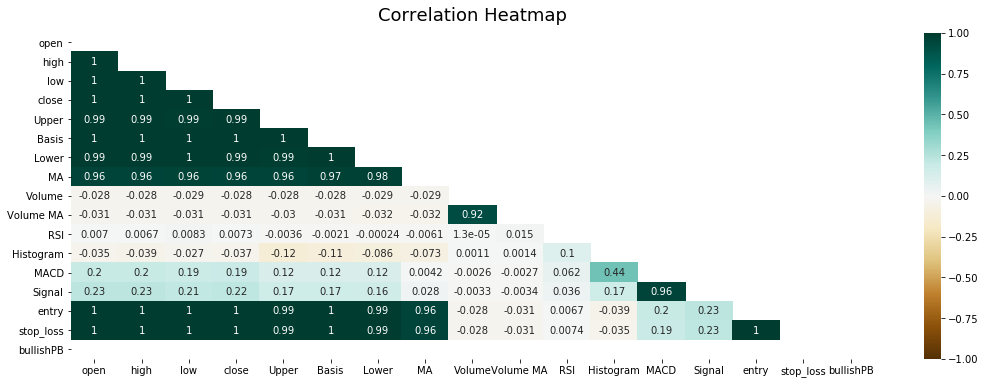

In [28]:
plt.figure(figsize=(18, 6))
np.triu(np.ones_like(X_train.corr()))
mask = np.triu(np.ones_like(X_train.corr(), dtype=np.bool))
heatmap = sns.heatmap(X_train.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

### Creating Relation Features

In [26]:
def creating_relation_features(df):
    df["relation_upper"] = ""
    df["relation_basis"] = ""
    df["relation_lower"] = ""
    df["relation_200MA"] = ""
    for i, row in df.iterrows():
    
        df.at[i, "relation_upper"] = (df.at[i, "Upper"] - df.at[i, "close"]) / (df.at[i, "Upper"] / 100)
        df.at[i, "relation_basis"] = (df.at[i, "Basis"] - df.at[i, "close"]) / (df.at[i, "Basis"] / 100)
        df.at[i, "relation_lower"] = (df.at[i, "Lower"] - df.at[i, "close"]) / (df.at[i, "Lower"] / 100)
        df.at[i, "relation_200MA"] = (df.at[i, "close"] - df.at[i, "MA"]) / (df.at[i, "close"] / 100)    

    return df

In [27]:
X_train = creating_relation_features(X_train)

In [28]:
X_test = creating_relation_features(X_test)

### Selecting only relevant features

In [30]:
def relevant_features(df):
    df = df[["Volume", "Volume MA", "MACD", "Signal", "RSI", "relation_upper", "relation_basis", "relation_lower", "relation_200MA"]]
    #df = df[["RSI","MACD", "Signal"]]
    return df

In [31]:
X_train = relevant_features(X_train)

In [32]:
X_test = relevant_features(X_test)

### Random Forests

In [33]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=42, n_jobs=4, class_weight = 'balanced_subsample')

In [34]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=4, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [35]:
rf_model.score(X_train, y_train)

0.5846930012881065

In [36]:
rf_model.score(X_test, y_test)

0.5745813653928725

## GridSearch Random Forests

In [68]:
n_estimators = [200, 400, 1000]
max_features = ["auto", "sqrt"]
max_depth = [4,6,8,10]
criterion = ["gini", "entropy"]
#min_sample_split = [2,5]
#min_sample_leaf = [1,2]
#bootstrap = [True, False]

In [69]:
rf_model = RandomForestClassifier(class_weight = 'balanced_subsample')

In [70]:
param_grid = {"n_estimators": n_estimators,
              "max_features": max_features,
              "max_depth": max_depth,
              "criterion": criterion}
              

In [74]:
rf_Grid = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv = 3, verbose = 2, n_jobs = 4)

In [75]:
%%time
rf_Grid.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 25.9min
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed: 195.4min finished


CPU times: user 2min 34s, sys: 4.97 s, total: 2min 39s
Wall time: 3h 20min 7s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                   

In [76]:
rf_Grid.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 400}

### rf_Grid

In [77]:
rf_grid = RandomForestClassifier(random_state=42, max_features = 'sqrt', n_estimators = 400, max_depth = 10, criterion = 'gini', class_weight = 'balanced_subsample')

In [78]:
%%time
rf_grid.fit(X_train, y_train)

CPU times: user 2min 10s, sys: 2.58 s, total: 2min 13s
Wall time: 2min 54s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=400, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [79]:
rf_grid.score(X_train, y_train)

0.8275440103048519

In [80]:
rf_grid.score(X_test, y_test)

0.7481322455989695

In [81]:
%%time
cross_val_result = cross_val_score(rf_grid, X_train, y_train)
cross_val_result.mean()

CPU times: user 8min 30s, sys: 10.7 s, total: 8min 40s
Wall time: 11min 7s


0.7575783598110777

### Save Model in Pickle

In [84]:
with open ('rf_grid_10x_pickle', 'wb') as f:
    pickle.dump(rf_grid,f)